In [1]:
# データ分析・操作用ライブラリ
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import itertools
from collections import Counter

# NLP用ライブラリ
from wordcloud import WordCloud
import MeCab,re
from sklearn.feature_extraction.text import TfidfVectorizer

# スコア評価用ライブラリ
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support

# その他
import glob
import warnings

In [2]:
# 表示関連
# DataFrameの列数設定
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

In [3]:
# 形態素解析用関数
def tokenize(text,wordClassList):
    tokens = []
    tagger = MeCab.Tagger()
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in wordClassList :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [4]:
# CSVの読み込み
wikiData = pd.read_csv("csv/train.csv", encoding="utf-8")

# クラス名の取得
fileNames = glob.glob('xml/*')
classList = []
for file in fileNames:
    classList.append(file[4:])

# 読み込みデータの表示
wikiData.head()

,text,target
0,ドール・フード・カンパニー ドール・フード・カンパニー（Dole Food Compan...,1
1,南ヶ丘牧場 株式会社 南ヶ丘牧場（みなみがおかぼくじょう）は、栃木県那須高原に本拠を置く...,1
2,岩瀬牧場 岩瀬牧場（いわせぼくじょう）は、日本の福島県岩瀬郡鏡石町にある牧場である。 ...,1
3,"クラギ クラギ株式会社（くらぎ、""KURAGI Co.Ltd."" ）は、三重県を中心に「...",1
4,"ハッピーネモファーム 株式会社ハッピーネモファーム（""""）は、北海道浦河郡浦河町にある競...",1


In [5]:
# 数字の除外
wikiData['text'] = wikiData['text'].str.replace('[0-9]+','', regex=True)

# 不要な記号の除外
path = "data/Removal Symbols.txt"
removal_symbols = []
with open(path, encoding="utf-8") as f:
    removal_symbols = [s.strip() for s in f.readlines()]
print(removal_symbols)

for symbol in removal_symbols:
    wikiData['text'] = wikiData['text'].str.replace(symbol,'')

['(', ')', '（', '）', '"', '""', '「', '」', '[', ']', '', '', '']


In [6]:
# データの表示
wikiData

,text,target
0,ドール・フード・カンパニー ドール・フード・カンパニーDole Food Company...,1
1,南ヶ丘牧場 株式会社 南ヶ丘牧場みなみがおかぼくじょうは、栃木県那須高原に本拠を置く酪農...,1
2,岩瀬牧場 岩瀬牧場いわせぼくじょうは、日本の福島県岩瀬郡鏡石町にある牧場である。 鏡石...,1
3,クラギ クラギ株式会社くらぎ、KURAGI Co.Ltd. は、三重県を中心に農業屋など...,1
4,ハッピーネモファーム 株式会社ハッピーネモファームは、北海道浦河郡浦河町にある競走馬サラ...,1
...,...,...
11455,チョイスホテルズジャパン 株式会社チョイスホテルズジャパンは、東京都中央区に本社を置くホ...,33
11456,キング観光 株式会社キング観光キングかんこうは、三重県桑名市に本社を置くパチンコチェーン...,33
11457,夢コーポレーション 夢コーポレーション株式会社は、全国にパチンコホール夢屋、スロットクラ...,33
11458,WILLER WILLER株式会社ウィラーは、旅行業を中心とした複数の企業を傘下に持つ企...,33


# データ数の確認

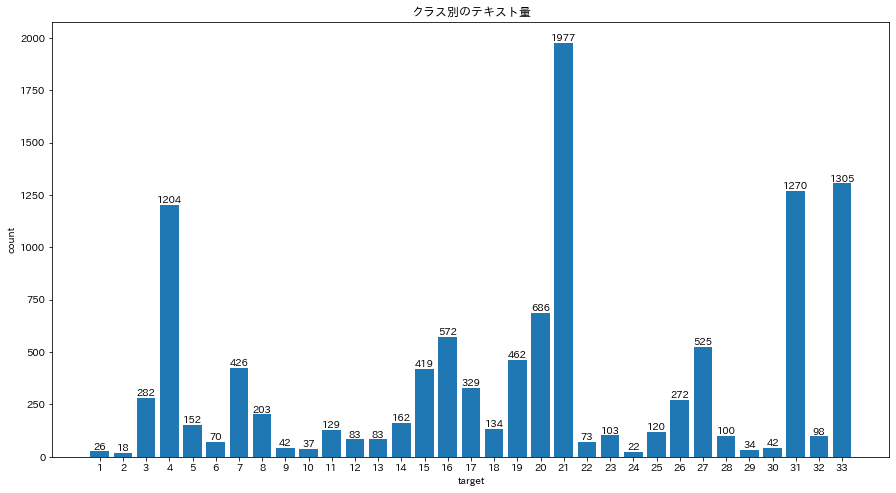

In [7]:
# クラス別のテキスト量を確認
wiki_gpby = wikiData.groupby('target').count()
y = wiki_gpby['text'].values
x =wiki_gpby.index.values

plt.figure(figsize=(15, 8))
plt.title("クラス別のテキスト量")
plt.xlabel("target")   
plt.ylabel("count")
plt.xticks(x)
plt.bar(x, y)

# 棒グラフ内に数値を書く
for t, c in zip(x, y):
    plt.text(t, c, c, ha='center', va='bottom')
    
plt.show()

・サンプル数にばらつきがある。最も少ないクラスは18個しか存在せず、学習するのに十分な数があるとは言えない

・不均衡データである為ダウンサンプリングも選択肢の一つだが、数が著しく少ないクラスが多く、学習データが少なくなりすぎそう

# WordCloud

In [8]:
# ストップワードの読み込み
path = "data/Slothlib.txt"
stopWords = []
with open(path, encoding="utf-8") as f:
    stopWords = [s.strip() for s in f.readlines()]

In [9]:
# 全テキストの結合
allText = ''
for text in wikiData['text'].values:
    allText += ''.join(text)

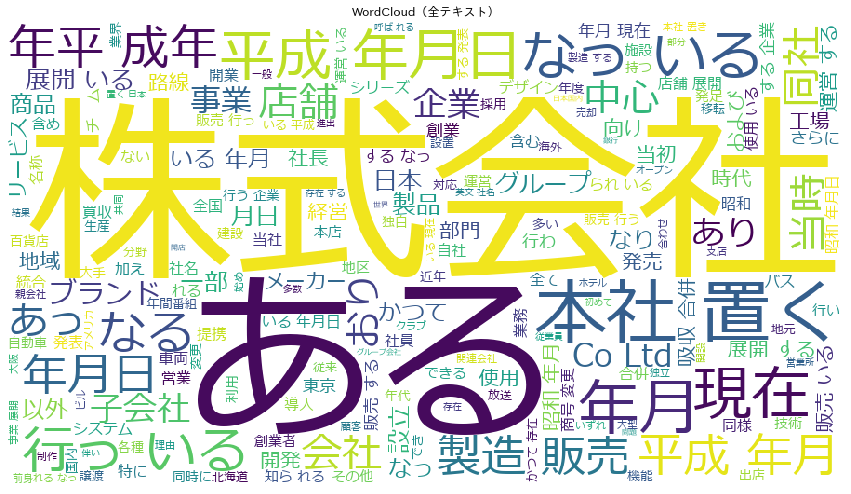

In [17]:
# 形態素解析
wordClassList = ['形容詞', '動詞','名詞', '副詞']
words = tokenize(allText,wordClassList)
words_joined = ' '.join(words)


# WordCloud
fpath = 'Fonts/meiryo.ttc'
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(words_joined)

plt.figure(figsize=(15,12))

plt.title("WordCloud（全テキスト）")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [18]:
# 単語別の出現回数を確認
counter = Counter(words)
wordCount = pd.DataFrame(counter.most_common(),columns = ['word','count'])
wordCount

,word,count
0,し,91312
1,年,39489
2,いる,38419
3,れ,30712
4,さ,30585
...,...,...
144063,ウィラー,1
144064,WILLER ALLIANCE,1
144065,北近畿タンゴ鉄道,1
144066,WILLER TRAINS,1


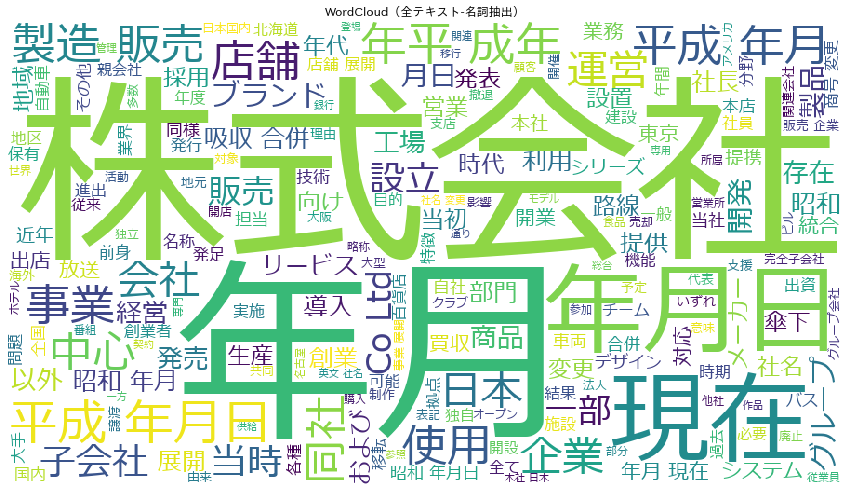

In [19]:
# 名詞のみ抽出
wordClassList = ['名詞']
words = tokenize(allText,wordClassList)
noun_joined = ' '.join(words)

# WordCloud
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(noun_joined)

plt.figure(figsize=(15,12))
plt.title("WordCloud（全テキスト-名詞抽出）")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

・'株式会社'、'同社'、'CO Ltd'など、どの業種でも出てくる単語や'平成'、'昭和'、'同年'、'当時'などの時を示す単語が多い。削除候補。

・'製造'、'販売'などの単語を名詞として抜けるようなので、動詞はいらなそう

In [20]:
# 単語別の出現回数を確認
counter = Counter(words)
wordCount = pd.DataFrame(counter.most_common(),columns = ['word','count'])
wordCount

,word,count
0,年,39489
1,年月,18030
2,年月日,15521
3,こと,14626
4,株式会社,11037
...,...,...
137041,ウィラー,1
137042,WILLER ALLIANCE,1
137043,北近畿タンゴ鉄道,1
137044,WILLER TRAINS,1


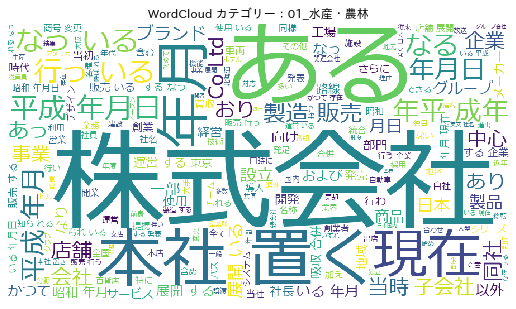

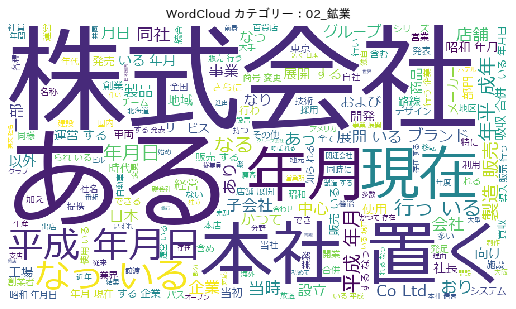

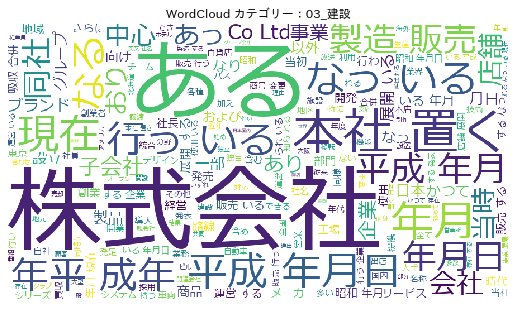

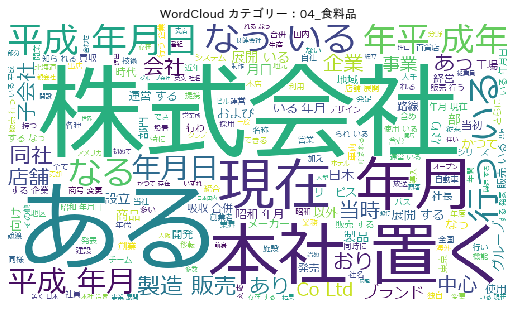

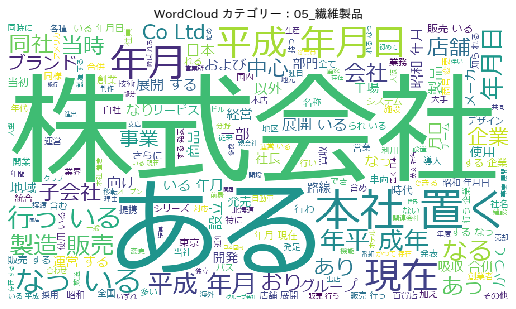

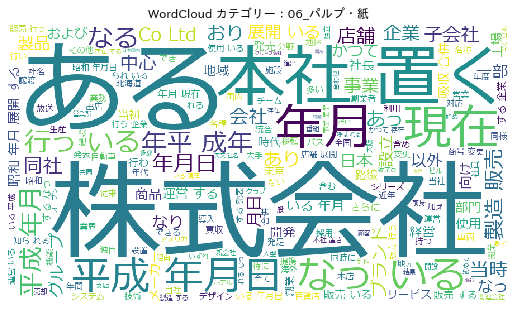

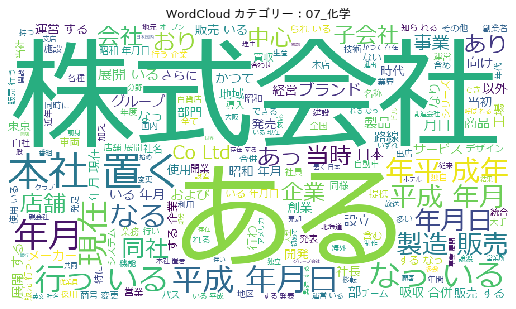

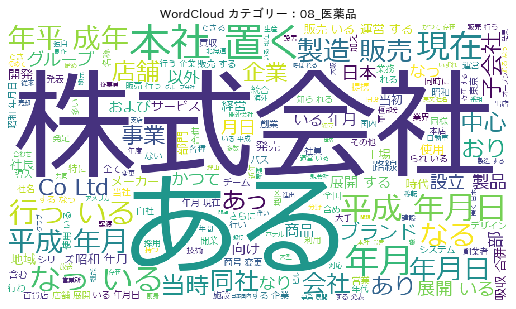

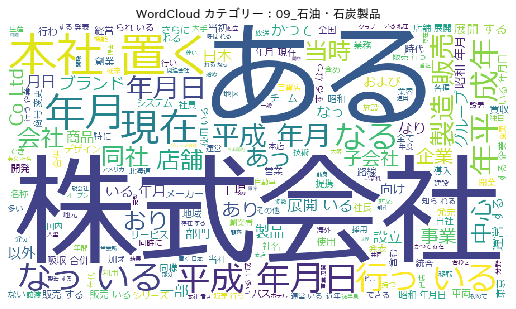

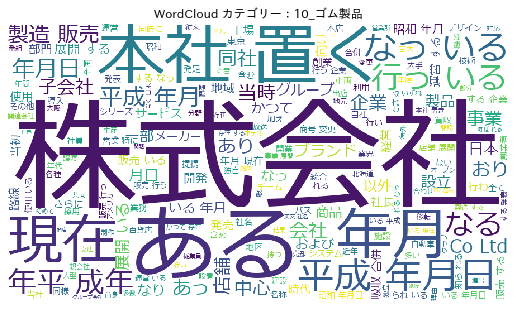

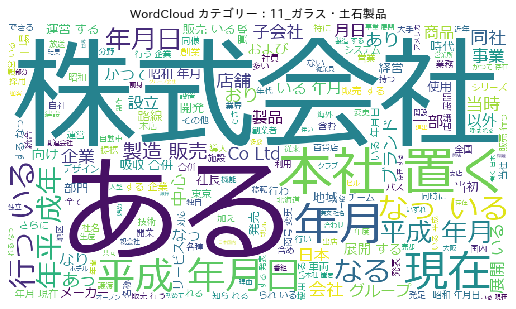

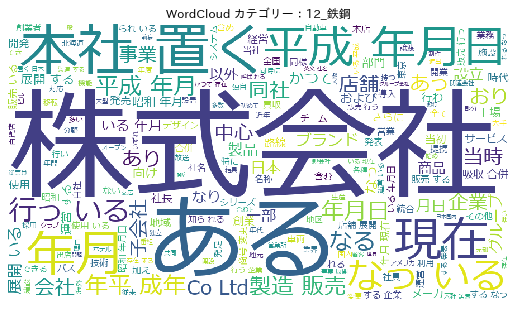

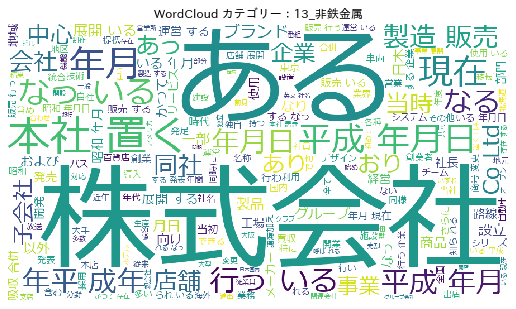

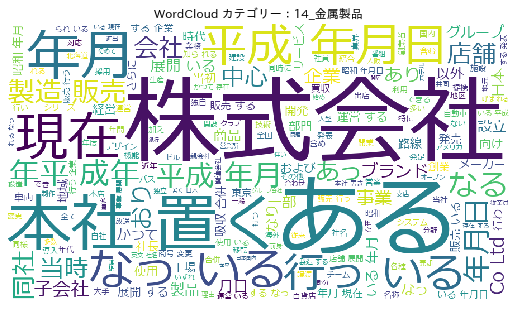

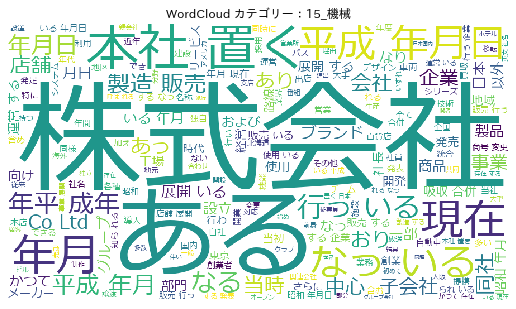

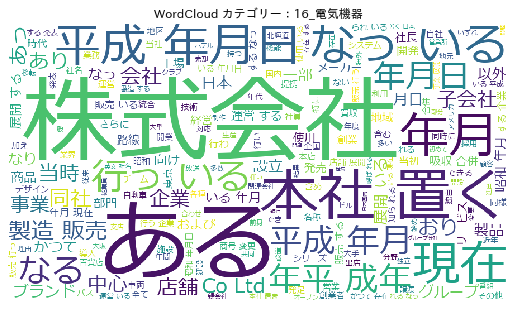

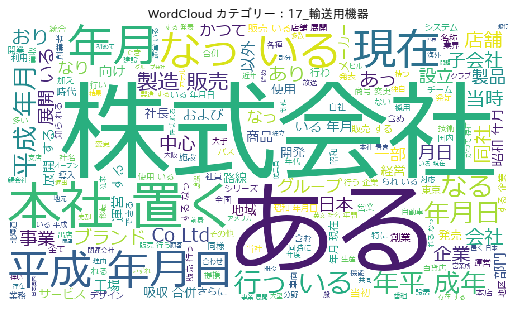

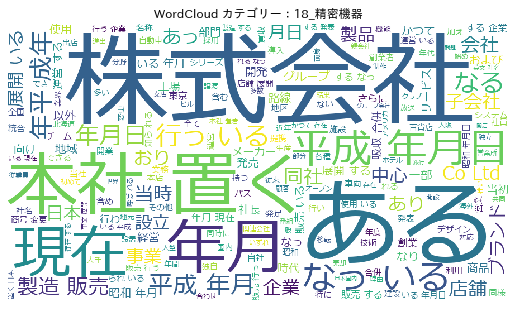

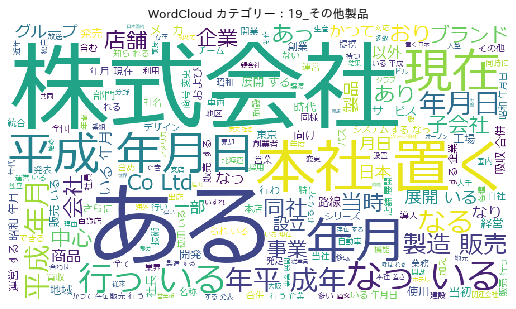

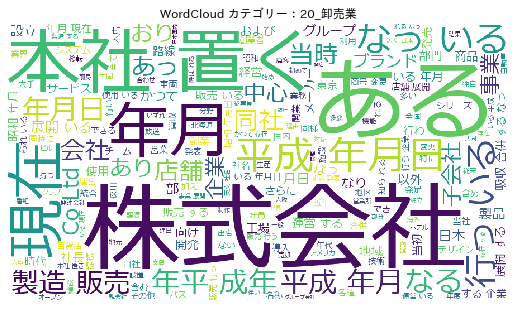

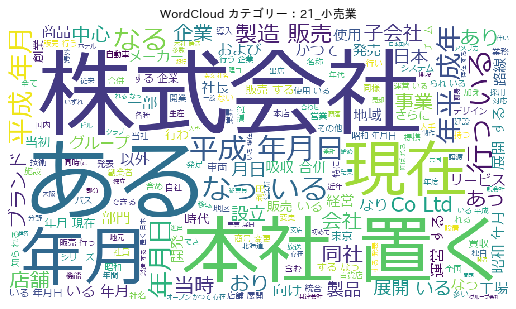

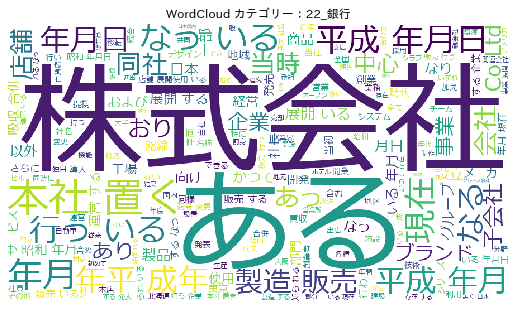

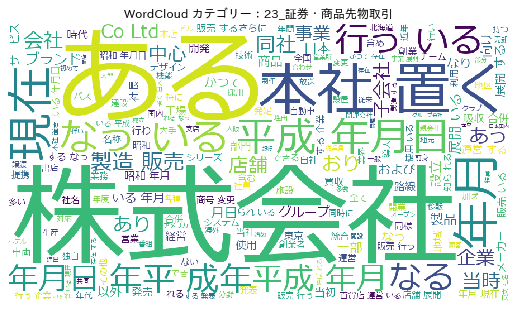

In [ ]:
# カテゴリー別に表示
targetText = ''
for i in range(1,34):
    targetData = wikiData[wikiData['target'] == i]
    
    for text in targetData['text'].values:
        targetText += "".join(text)
    
    # 形態素解析
    wordClassList = ['形容詞', '動詞','名詞', '副詞']
    words = tokenize(allText,wordClassList)
    words_joined = ' '.join(words)
    
    # WordCloud
    wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(words_joined)

    plt.figure(figsize=(9,6))
    plt.title("WordCloud カテゴリー：" + classList[i-1])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    targetText = ''


In [ ]:
# カテゴリー別に表示
targetText = ' '
for i in range(1,34):
    targetData = wikiData[wikiData['target'] == i]
    for text in targetData['text'].values:
        targetText += ''.join(text)
    
    # 名詞のみ抽出
    wordClassList = ['名詞']
    targetWords = tokenize(targetText,wordClassList)
    noun_joined = ' '.join(targetWords)
    
    # WordCloud
    wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, stopwords=set(stopWords)).generate(noun_joined)

    plt.figure(figsize=(9,6))
    plt.title("WordCloud（名詞抽出） カテゴリー：" + classList[i-1])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    targetText = ''

### 試しにLight GBMでスコアを出してみる

In [ ]:
# Numpy配列へ変換
X_text = wikiData.text.values
y_target = wikiData.target.values

In [ ]:
# トレーニングデータ、テストデータの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_text , y_target, test_size=0.2, random_state=42, stratify=y_target)

In [ ]:
# TfidfVectorizerで使うtokenizer
def Tfidf_tokenize(text):
    tokens = []
    tagger = MeCab.Tagger( "-Ochasen" )
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in ['形容詞', '動詞','名詞', '副詞'] :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [ ]:
# TF-IDFへ変換
vectorizer = TfidfVectorizer(tokenizer=Tfidf_tokenize)
vectorizer.fit(X_train)
train_matrix = vectorizer.transform(X_train).toarray()
test_matrix = vectorizer.transform(X_test).toarray()

In [ ]:
# Light GBM
import lightgbm as lgb

clf = lgb.LGBMClassifier(objective='multiclass', num_class=33)
clf.fit(train_matrix, y_train)
cv_scores = cross_val_score(clf, train_matrix, y_train, cv=5)

print("Training score：" + str(clf.score(train_matrix, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf.score(test_matrix, y_test)))

In [ ]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf.predict(test_matrix)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

In [ ]:
# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

In [ ]:
# テキスト量へF1値を書き込んでみる
plt.figure(figsize=(15, 8))
plt.title("クラス別のテキスト量　& F1値")
plt.xlabel("target")   
plt.ylabel("count")
plt.xticks(x)
plt.bar(x, y)

# 棒グラフ内にF1値を書く
for t, c, f in zip(x, y, p_r_f[2]):
    plt.text(t, c, round(f,2), ha='center', va='bottom')
    
plt.show()

テキスト量の少ないクラスはF1値が軒並み低いかと思われたが、僅かなデータ量でも銀行や保険、海運、空運のようなクラスはスコアが良い。悪いクラスとの差異は何なのか考える。

### TF-IDFの重要語を確認

In [ ]:
index = test_matrix.argsort(axis=1)[:,::-1]

In [ ]:
feature_names = np.array(vectorizer.get_feature_names())
feature_words = feature_names[index[:1000]]

In [ ]:
for fwords, target in zip(feature_words[:,:10], y_test):
    # 各文書ごとにtarget（ラベル）とtop 10の重要語を表示
    if target in [1,2,22,23,28,29]:
        print(target)
        print(fwords)

・銀行や保険、海運は特徴的な語句を抜けている

・水産-農業、鉱業も的外れな語句が抜けているようには感じない。テキスト量、単語量の差でTfidfの値が低いのか？

In [ ]:
pd_Tfidf = pd_DataFrame(test_matrix, columns = vectorizer.get_feature_names())